In [1]:
# Add local scripts to module search path
import sys
import os
sys.path.append(os.path.realpath('../toliman-proper'))

## Calculated PSF from PROPER

In [2]:
from spirals import binarized_ringed_flipped

def binarized_ringed_650(r, phi):
    phase = 650.*1e-9*0.5
    return binarized_ringed_flipped(r, phi, phase)
beam_ratio = 0.4
toliman_settings = {
                    'diam': 0.001 * 2. * 150, 
                    'm1_fl': 571.7300 / 1000.,
                    'm1_m2_sep': 549.240/1000.,
                    'm2_fl': -23.3800/1000.,
                    'bfl': 590.000 / 1000., 
                    'm2_rad': 5.9 / 1000., 
                    'm2_strut_width': 0.01,
                    'm2_supports': 5,
                    'beam_ratio': beam_ratio,
                    'tilt_x': 0.00,
                    'tilt_y': 0.00,
                    'phase_func': binarized_ringed_650,
                    'm1_hole_rad':0.025,
                    'use_caching':True
                    }

gridsize = 2048 # sampling of wavefront
wavelength = 0.65 # micros
# First source, on axis
source = {
            'wavelengths': [wavelength],
            'weights': [1.],
            'settings': toliman_settings
            }


In [3]:
import proper
detector_pitch = 11.0e-6 # m/pixel on detector
npixels = 512 # Size of detector, in pixels

# Calculated PSF
from proper_tools import form_detector_image
raw_image = form_detector_image('prescription_rc_quad', [source], gridsize, detector_pitch, npixels)#,multi=False)


/suphys/bjef8061/.local/lib/python3.5/site-packages/pyfits-3.5-py3.5-linux-x86_64.egg/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


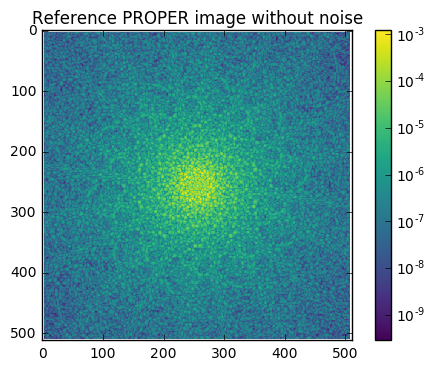

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.imshow(raw_image, interpolation = 'none', cmap='viridis',norm=LogNorm())
plt.colorbar()
plt.title('Reference PROPER image without noise')
plt.show()

## Add Poisson noise

Scale image to have a peak of 25k to be below saturation, then add photon noise by drawing random values from a Poisson distribution.

In [5]:
intensity_scale = (25000/raw_image.max(axis=None))
detector_image = np.random.poisson(
    intensity_scale*np.clip(raw_image,0.,1.)
)

In [6]:
# Get lower bound on error
min_err = np.sum((detector_image - intensity_scale*raw_image)**2) 
print(min_err)

18553620.0177


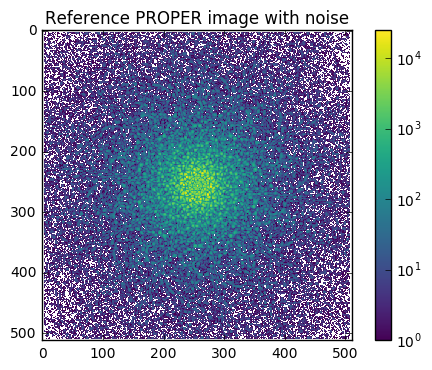

In [7]:
plt.imshow(detector_image, interpolation = 'none', cmap='viridis',norm=LogNorm())
plt.colorbar()
plt.title('Reference PROPER image with noise')
plt.show()

# Fit by tweaking position


In [8]:
# Function to generate 
errors = []
def model_err(pos, view=False):
    tiltx = pos[0]
    tilty = pos[1]
    settings = toliman_settings.copy()
    settings['tilt_x'] = tiltx 
    settings['tilt_y'] = tilty
    source = {
            'wavelengths': [wavelength],
            'weights': [1.],
            'settings': settings
            }
    im = form_detector_image('prescription_rc_quad', [source], gridsize, detector_pitch, npixels)
    # Adjust scale
    im *= intensity_scale
    if view:
        plt.imshow(im, interpolation = 'none', cmap='viridis',norm=LogNorm())
        plt.colorbar()
        #plt.title('Reference PROPER image with noise')
        plt.show()
    error = np.sum((im - detector_image)**2)
    errors.append((pos,error))
    print('Error for offset ({},{}): {} '.format(tiltx, tiltx, error))
    return error

## Sanity check

How does error value vary over reasonable range? 

In [9]:
errors = []
for dx in [-0.5, -0.25, 0, 0.25, 0.5]:
    for dy in [-0.5, -0.25, 0, 0.25, 0.5]:
        model_err([dx,dy], view=False)

Calculated image error  78080926286.2
Calculated image error  81605988468.5
Calculated image error  83176746405.6
Calculated image error  81480132058.9
Calculated image error  78714727212.7
Calculated image error  81623534369.6
Calculated image error  74781890296.4
Calculated image error  52054170471.2
Calculated image error  74797738729.9
Calculated image error  81466141371.7
Calculated image error  83214690117.5
Calculated image error  52052144636.5
Calculated image error  18553620.0177
Calculated image error  52040302622.6
Calculated image error  83166069747.8
Calculated image error  81475287710.1
Calculated image error  74755331790.7
Calculated image error  52034514981.8
Calculated image error  74775042620.6
Calculated image error  81597023042.4
Calculated image error  78691560114.3
Calculated image error  81453933030.4
Calculated image error  83200070499.0
Calculated image error  81600616403.9
Calculated image error  78074107142.2


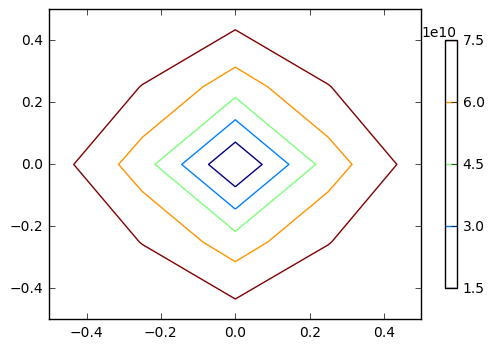

In [21]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

X,Y  = np.meshgrid([-0.5, -0.25, 0, 0.25, 0.5],[-0.5, -0.25, 0, 0.25, 0.5])
plt.figure()
Z = np.reshape([e for ((dx,dy),e) in errors],(5,5), order='F')
CS = plt.contour(X, Y, Z)
plt.colorbar(CS, shrink=0.8, extend='both')
plt.show()

## Optimize

### Nelder-Mead Simplex algorithm

This is a popular derivative-free multivariate minimization algorithm.

In [23]:
from scipy.optimize import minimize
errors=[]
dir_init = [0.01, 0.01]
opt = minimize(model_err, dir_init, method='nelder-mead')

Calculated image error  252977902.126
Calculated image error  264973511.557
Calculated image error  265004531.132
Calculated image error  253533289.465
Calculated image error  241536388.045
Calculated image error  230255794.59
Calculated image error  230286833.124
Calculated image error  208439876.344
Calculated image error  187924225.696
Calculated image error  188479945.899
Calculated image error  150534304.882
Calculated image error  117697577.928
Calculated image error  117728665.907
Calculated image error  65962906.0338
Calculated image error  33141704.4738
Calculated image error  33698270.7105
Calculated image error  24037859.0166
Calculated image error  90011769.2058
Calculated image error  24068872.3718
Calculated image error  89880364.161
Calculated image error  19120369.2101
Calculated image error  19677044.4639
Calculated image error  33273074.332
Calculated image error  19293816.8403
Calculated image error  19324855.9285
Calculated image error  18724133.9842
Calculated imag

In [27]:
print(opt)

 final_simplex: (array([[  2.21412436e-05,  -4.26772596e-06],
       [  2.21439712e-05,  -4.26340175e-06],
       [  2.21540981e-05,  -4.26868721e-06]]), array([ 18553022.05161107,  18553022.05161191,  18553022.05163927]))
           fun: 18553022.051611066
       message: 'Optimization terminated successfully.'
          nfev: 98
           nit: 54
        status: 0
       success: True
             x: array([  2.21412436e-05,  -4.26772596e-06])


In [28]:
# How do things look now?
tiltx = opt.x[0]
tilty = opt.x[1]
settings = toliman_settings.copy()
settings['tilt_x'] = tiltx 
settings['tilt_y'] = tilty
source = {
        'wavelengths': [wavelength],
        'weights': [1.],
        'settings': settings
        }
final = form_detector_image('prescription_rc_quad', [source], gridsize, detector_pitch, npixels)

In [29]:
final *= intensity_scale

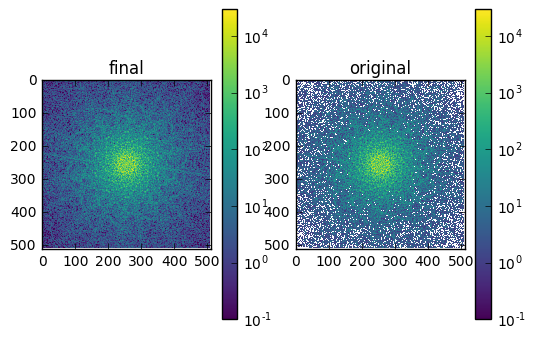

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2)
im=axes[0].imshow(final, interpolation = 'none', cmap='viridis',aspect='equal', norm=LogNorm() ,vmin=1e-1, vmax=30000)
axes[0].set_title('final')
plt.colorbar(im, ax=axes[0])
im=axes[1].imshow(detector_image, interpolation = 'none', cmap='viridis',aspect='equal',norm=LogNorm(),vmin=1e-1, vmax=30000)
axes[1].set_title('original')
plt.colorbar(im, ax=axes[1])
plt.show()

In [31]:
print("Final error {:.2e} vs. minimum bound of {:.2e}".format(np.sum((detector_image - final)**2), min_err))

Final error 1.86e+07 vs. minimum bound of 1.86e+07


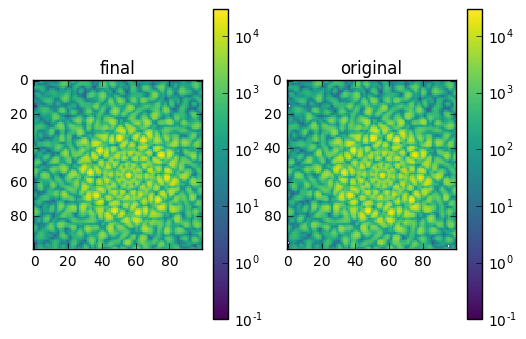

In [32]:
# zoom into central region
fig, axes = plt.subplots(nrows=1, ncols=2)
im=axes[0].imshow(final[200:300,200:300], interpolation = 'none', cmap='viridis',aspect='equal', norm=LogNorm() ,vmin=1e-1, vmax=30000)
axes[0].set_title('final')
plt.colorbar(im, ax=axes[0])
im=axes[1].imshow(detector_image[200:300,200:300], interpolation = 'none', cmap='viridis',aspect='equal',norm=LogNorm(),vmin=1e-1, vmax=30000)
axes[1].set_title('original')
plt.colorbar(im, ax=axes[1])
plt.show()

-0.0055 0.0105 -0.00575 0.0105


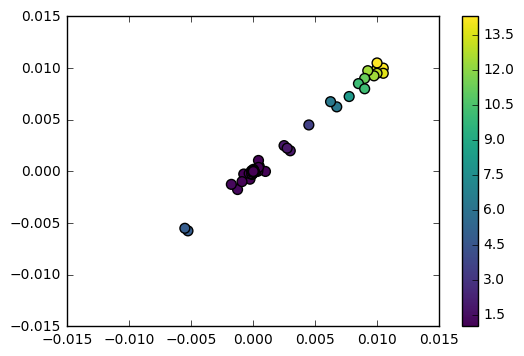

In [47]:
#Visualise the space explored by the optimiser
import matplotlib.pyplot as plt

(X,Y,E) = zip(*[(dx,dy,e) for ((dx,dy),e) in errors])

#color = [str(item/255.) for item in y]
print(np.min(X),np.max(X),np.min(Y),np.max(Y))
plt.scatter(X, Y, s=50, c=[e/min_err for e in E], cmap='viridis' )
plt.xlim(-0.015,0.015)
plt.ylim(-0.015,0.015)
plt.colorbar()
plt.show()